# Cyclistic Case Study

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import plotly.express as px
import folium

## Data Processing

In [2]:
# function to convert timedelta to hours:minutes:seconds format
def format_duration(datetime):    
    # convert timedelta to total seconds
    total_seconds = datetime.total_seconds()
    
    # calculate hours, minutes, and seconds
    hours = int(total_seconds // 3600)
    minutes = int((total_seconds % 3600) // 60)
    seconds = int(total_seconds % 60)
    
    # format into h:m:s format
    formatted_time = f"{hours:02}:{minutes:02}:{seconds:02}"
    
    return formatted_time

In [3]:
# function to categorize into hourly bins
def categorize_hour(hour):
    period = "AM" if hour < 12 else "PM"
    hour_label = hour % 12
    hour_label = 12 if hour_label == 0 else hour_label
    
    return f"{hour_label}:00{period}"

In [4]:
# function to categorize months into seasons
def categorize_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall' 

In [5]:
# function to convert datatype of time column from strings to total minutes
def to_minutes(time_str):
    hours, minutes, seconds = map(int, time_str.split(':'))
    total_minutes = hours*60 + minutes + seconds/60
    return total_minutes

In [6]:
# create a user-defined function for data processing on the dataframes
def process_data(chunk):   
 
    # remove the extra spaces from column headers if any
    chunk.columns = chunk.columns.str.strip()
    
    # remove fractional seconds from started_at & ended_at columns
    chunk["started_at"] = chunk["started_at"].str.split('.').str[0]
    chunk["ended_at"] = chunk["ended_at"].str.split('.').str[0]
    
    # change the datatype of started_at & ended_at columns to datetime
    chunk["started_at"] = pd.to_datetime(chunk["started_at"])
    chunk["ended_at"] = pd.to_datetime(chunk["ended_at"])

    # create a column ride_length
    chunk["ride_length"] = chunk["ended_at"] - chunk["started_at"]

    # create a column day_of_week
    chunk["day_of_week"] = chunk["started_at"].dt.strftime('%A')

    # create a column month_of_year
    chunk["month_of_year"] = chunk["started_at"].dt.strftime('%B')
    
    # create a new column start_hour
    chunk["start_hour"] = chunk["started_at"].dt.hour.apply(categorize_hour)

    # create a column season_of_year            
    chunk["season_of_year"] = chunk["started_at"].dt.month.apply(categorize_season)
    
    return chunk

In [7]:
# initialize empty dataframe to collect processed dataframes 
processed_data = pd.DataFrame()

In [8]:
# list of file paths
file_paths = [
    "202307-divvy-tripdata.csv",
    "202308-divvy-tripdata.csv",
    "202309-divvy-tripdata.csv",
    "202310-divvy-tripdata.csv",
    "202311-divvy-tripdata.csv",
    "202312-divvy-tripdata.csv",
    "202401-divvy-tripdata.csv",
    "202402-divvy-tripdata.csv",
    "202403-divvy-tripdata.csv",
    "202404-divvy-tripdata.csv",
    "202405-divvy-tripdata.csv",
    "202406-divvy-tripdata.csv"]

# process each file in chunks
for file_path in file_paths:
    
    # read the file in chunks
    chunk_file = pd.read_csv(file_path, chunksize=100000, encoding="unicode_escape")
    
    for chunk in chunk_file:
        processed_data = pd.concat([processed_data, process_data(chunk)])
        
# reset index after concatenation
processed_data.reset_index(drop=True, inplace=True)

In [9]:
# apply the format_duration function to the final DataFrame
processed_data["ride_length"] = processed_data["ride_length"].apply(format_duration)

In [10]:
# convert ride_length to total minutes for ease of calculation
processed_data["ride_len_min"] = processed_data["ride_length"].apply(to_minutes)

In [11]:
processed_data.shape

(5740211, 19)

In [12]:
processed_data.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,ride_length,day_of_week,month_of_year,start_hour,season_of_year,ride_len_min
0,9340B064F0AEE130,electric_bike,2023-07-23 20:06:14,2023-07-23 20:22:44,Kedzie Ave & 110th St,20204,Public Rack - Racine Ave & 109th Pl,877,41.692406,-87.700905,41.694835,-87.653041,member,00:16:30,Sunday,July,8:00PM,Summer,16.5
1,D1460EE3CE0D8AF8,classic_bike,2023-07-23 17:05:07,2023-07-23 17:18:37,Western Ave & Walton St,KA1504000103,Milwaukee Ave & Grand Ave,13033,41.898418,-87.686596,41.891578,-87.648384,member,00:13:30,Sunday,July,5:00PM,Summer,13.5


In [13]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5740211 entries, 0 to 5740210
Data columns (total 19 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             object        
 1   rideable_type       object        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  object        
 5   start_station_id    object        
 6   end_station_name    object        
 7   end_station_id      object        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       object        
 13  ride_length         object        
 14  day_of_week         object        
 15  month_of_year       object        
 16  start_hour          object        
 17  season_of_year      object        
 18  ride_len_min        float64       
dtypes: datetime64[ns](2), float64(5), object(1

In [14]:
processed_data.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    933350
start_station_id      933350
end_station_name      980959
end_station_id        980959
start_lat                  0
start_lng                  0
end_lat                 7936
end_lng                 7936
member_casual              0
ride_length                0
day_of_week                0
month_of_year              0
start_hour                 0
season_of_year             0
ride_len_min               0
dtype: int64

In [15]:
processed_data.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'ride_length', 'day_of_week', 'month_of_year',
       'start_hour', 'season_of_year', 'ride_len_min'],
      dtype='object')

## Data Analysis

In [16]:
# calculate average ride_length by user types
avg_ride_length = processed_data.groupby("member_casual")["ride_len_min"].mean().reset_index()

In [17]:
# calculate average ride_length by user types for days of the week
avg_ride_length_days = processed_data.groupby(["member_casual","day_of_week"])["ride_len_min"].mean().reset_index()

In [18]:
# calculate number of rides by user types
rides_count = processed_data.groupby("member_casual").size().reset_index(name="count")

In [19]:
# calculate number of rides by user types for days of the week
rides_count_days = processed_data.groupby(["member_casual","day_of_week"]).size().reset_index(name="count")

In [20]:
# calculate number of rides by user types for seasons of the year
rides_count_seasons = processed_data.groupby(["member_casual","season_of_year"]).size().reset_index(name="count")

In [21]:
# calculate number of rides per hour by user types
rides_per_hour = processed_data.groupby(["member_casual", "start_hour"]).size().reset_index(name="count")

In [22]:
# calculate popular bike category
popular_bike_category = processed_data.groupby(["rideable_type"]).size().reset_index(name="count")

In [23]:
# calculate popular bike category by user types
popular_bike_cat_by_user = processed_data.groupby(["rideable_type","member_casual"]).size().reset_index(name="count")

In [24]:
# filter for casual users
casual = processed_data.query("member_casual == 'casual'")

In [25]:
# calculate average ride_length for casual users by bike types
avg_ride_len_casual = casual.groupby("rideable_type")["ride_len_min"].mean().reset_index()

In [26]:
# calculate average ride_length of casual users by bike types for days of the week
avg_ride_len_casual_day = casual.groupby(["rideable_type","day_of_week"])["ride_len_min"].mean().reset_index()

In [27]:
# calculate number of rides by casual users for days of the week
rides_count_casual_days = casual.groupby(["rideable_type","day_of_week"]).size().reset_index(name="count")

In [28]:
# calculate number of rides per season of casual users by bike types
rides_count_seasons_casual = casual.groupby(["rideable_type", "season_of_year"]).size().reset_index(name="count")

In [29]:
# calculate ride ratio
ride_ratio = processed_data.groupby(["member_casual", "season_of_year"]).size().reset_index()
ride_ratio.columns = ['member_casual', 'season_of_year', 'count']

# calculate ride ratios for each season
ride_ratio_summer = (ride_ratio.query("(season_of_year == 'Summer') & (member_casual == 'member')")['count'].sum() /
                     ride_ratio.query("(season_of_year == 'Summer') & (member_casual == 'casual')")['count'].sum())

ride_ratio_fall = (ride_ratio.query("(season_of_year == 'Fall') & (member_casual == 'member')")['count'].sum() /
                   ride_ratio.query("(season_of_year == 'Fall') & (member_casual == 'casual')")['count'].sum())

ride_ratio_winter = (ride_ratio.query("(season_of_year == 'Winter') & (member_casual == 'member')")['count'].sum() /
                     ride_ratio.query("(season_of_year == 'Winter') & (member_casual == 'casual')")['count'].sum())

ride_ratio_spring = (ride_ratio.query("(season_of_year == 'Spring') & (member_casual == 'member')")['count'].sum() /
                     ride_ratio.query("(season_of_year == 'Spring') & (member_casual == 'casual')")['count'].sum())

# create the ratio_data DataFrame
ratio_data = pd.DataFrame({
    "season": ["Summer", "Fall", "Winter", "Spring"],
    "ride_ratio": [ride_ratio_summer, ride_ratio_fall, ride_ratio_winter, ride_ratio_spring]
})

In [30]:
# starting geolocation of casual users data excluding docked bike rides
start_location_casual = processed_data.query("(member_casual=='casual')&(rideable_type!='docked_bike')")

# group by station_id
start_location_casual_grouped = start_location_casual.groupby(["start_station_id","start_lat","start_lng"]).size().reset_index(name="count")


# get the top 5 station_ids with the highest count
start_location_casual_grouped = start_location_casual_grouped.nlargest(5, "count")                          

In [31]:
# ending geolocation of casual users data excluding docked bike rides
end_location_casual = processed_data.query("(member_casual=='casual')&(rideable_type!='docked_bike')")

# group by station_id
end_location_casual_grouped = end_location_casual.groupby(["end_station_id","end_lat","end_lng"]).size().reset_index(name="count")


# get the top 5 station_ids with the highest count
end_location_casual_grouped = end_location_casual_grouped.nlargest(5, "count")                          

In [32]:
# strating geolocation of member users data grouped by seasons
start_location_member = processed_data.query("(member_casual=='member')&(rideable_type!='docked_bike')")

# group by station_id
start_location_member_grouped = start_location_member.groupby(["start_station_id","start_lat","start_lng"]).size().reset_index(name="count")

# get the top 5 station_ids with the highest count
start_location_member_grouped = start_location_member_grouped.nlargest(5, "count")

In [33]:
# ending geolocation of member users data excluding docked bike rides
end_location_member = processed_data.query("(member_casual=='member')&(rideable_type!='docked_bike')")

# group by station_id
end_location_member_grouped = end_location_member.groupby(["end_station_id","end_lat","end_lng"]).size().reset_index(name="count")


# get the top 5 station_ids with the highest count
end_location_member_grouped = end_location_member_grouped.nlargest(5, "count")                          

## Data Visualisation

In [34]:
# set default figure size and font sizes for titles, xlabels, and ylabels

sns.set(rc={'figure.figsize': (20, 6),
            'axes.titlesize': 18,     # Title font size
            'axes.labelsize': 14,     # X and Y label font size
            'xtick.labelsize': 12,    # X tick label font size
            'ytick.labelsize': 12},   # Y tick label font size
        style = 'whitegrid'
       )  

sns.set_palette("hls", 8)

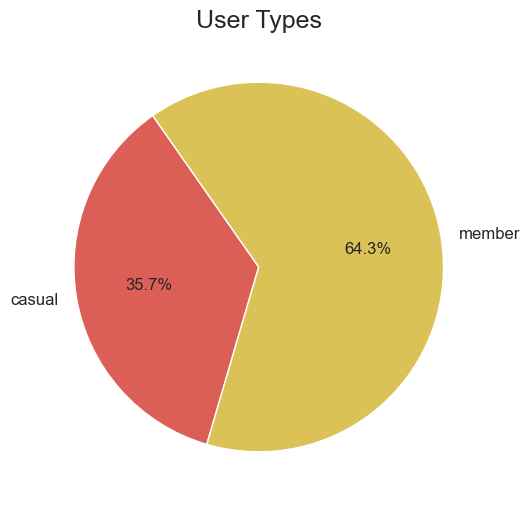

In [35]:
values = rides_count["count"]
labels = rides_count["member_casual"]

plt.pie(values, labels = labels, colors=sns.set_palette("hls", 8), autopct='%1.1f%%', startangle=125)

plt.title("User Types", fontsize=18)

plt.show()

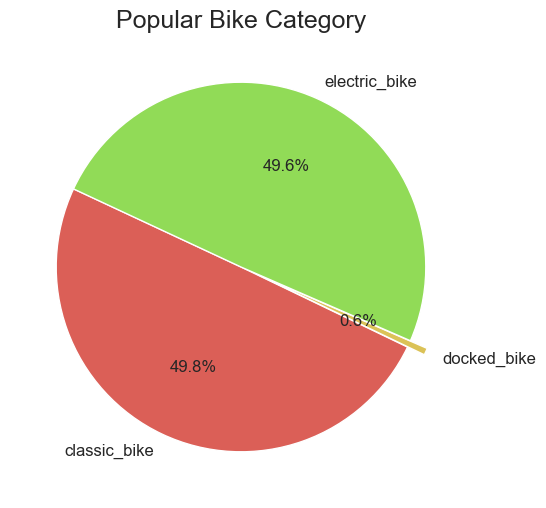

In [36]:
values = popular_bike_category["count"]
labels = popular_bike_category["rideable_type"]
explode = (0, 0.1, 0)

plt.pie(values, labels = labels, explode=explode, colors=sns.set_palette("hls", 8), autopct='%1.1f%%', startangle=155)

plt.title("Popular Bike Category", fontsize=18)

plt.show()

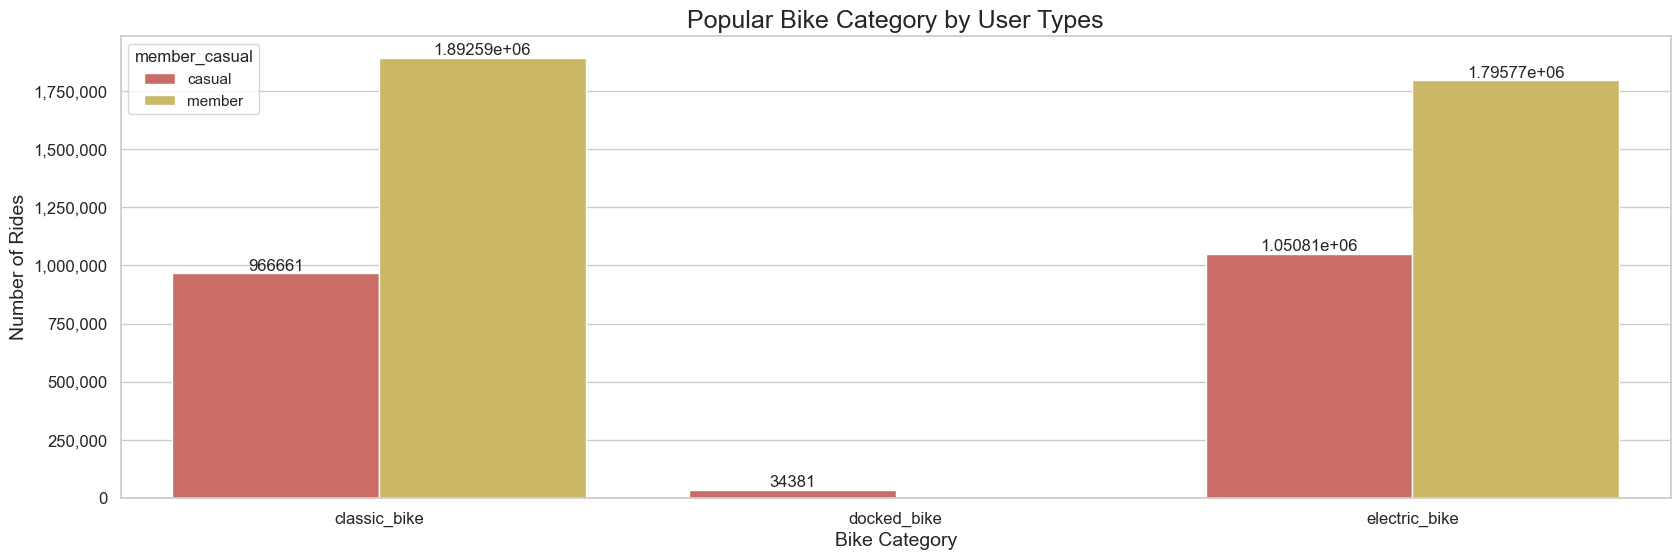

In [37]:
axs = sns.barplot(data = popular_bike_cat_by_user, x = "rideable_type", y = "count", hue = "member_casual")

axs.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: format(int(x), ',')))

for i in axs.containers:
    axs.bar_label(i, fontsize=12)
    
plt.xlabel("Bike Category")
plt.ylabel("Number of Rides")
plt.title("Popular Bike Category by User Types")

plt.show()

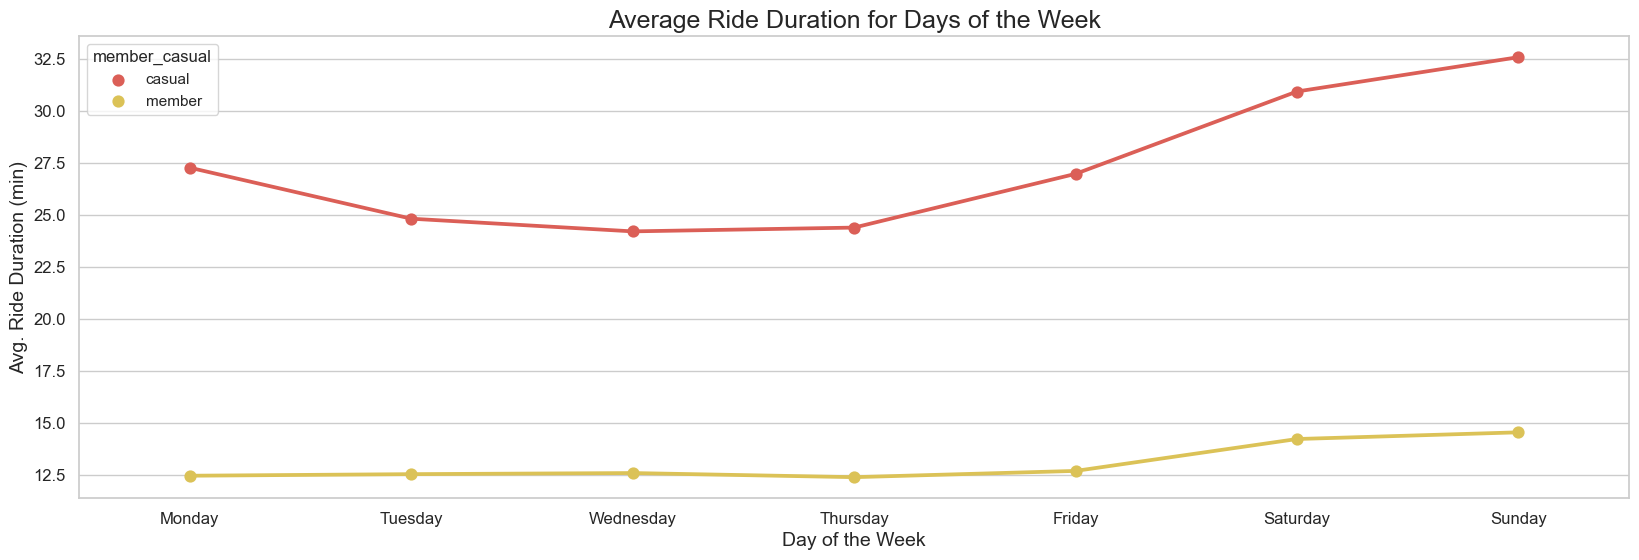

In [38]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.pointplot(x = "day_of_week", y = "ride_len_min", hue = "member_casual", order=order, data = avg_ride_length_days)

plt.xlabel("Day of the Week")
plt.ylabel("Avg. Ride Duration (min)")
plt.title("Average Ride Duration for Days of the Week")

plt.show()

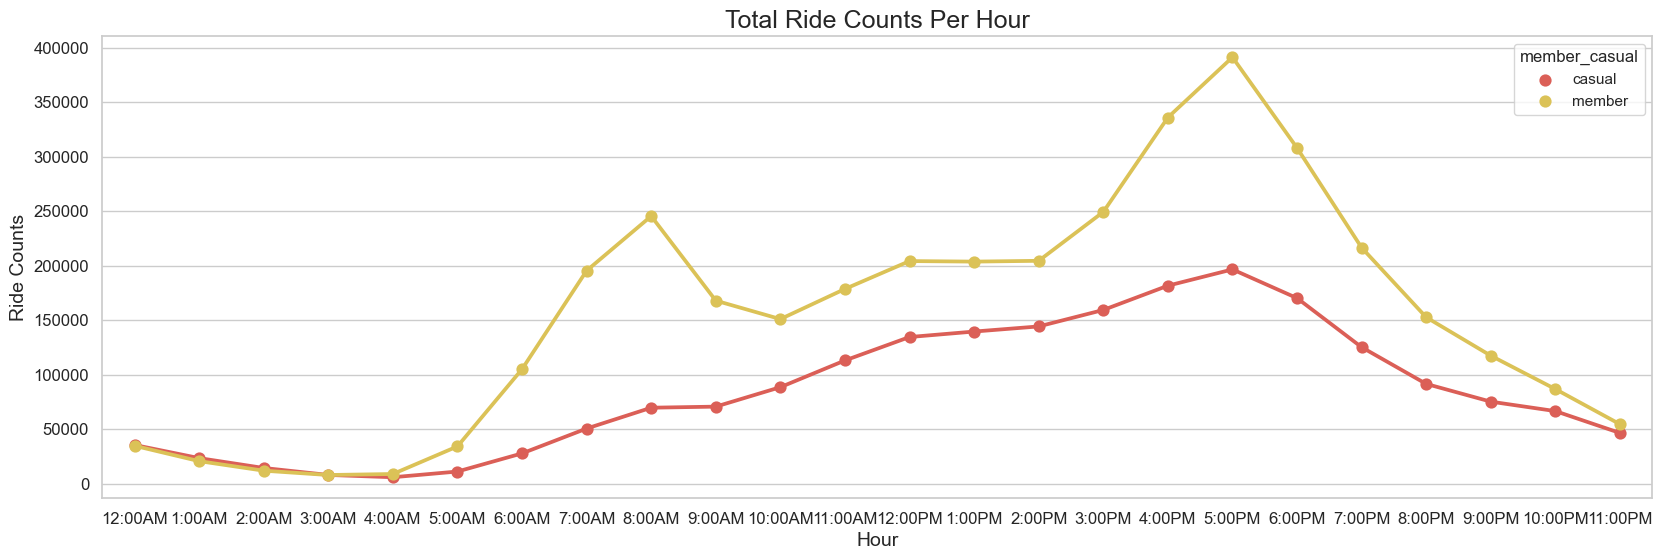

In [39]:
order = ["12:00AM", "1:00AM", "2:00AM", "3:00AM", "4:00AM", "5:00AM", "6:00AM", "7:00AM", "8:00AM",
         "9:00AM", "10:00AM", "11:00AM", "12:00PM", "1:00PM", "2:00PM", "3:00PM", "4:00PM", "5:00PM", "6:00PM", "7:00PM", "8:00PM",
         "9:00PM", "10:00PM", "11:00PM"]

sns.pointplot(x = "start_hour", y = "count", hue = "member_casual", order = order, data = rides_per_hour)

plt.xlabel("Hour")
plt.ylabel("Ride Counts")
plt.title("Total Ride Counts Per Hour")

plt.show()

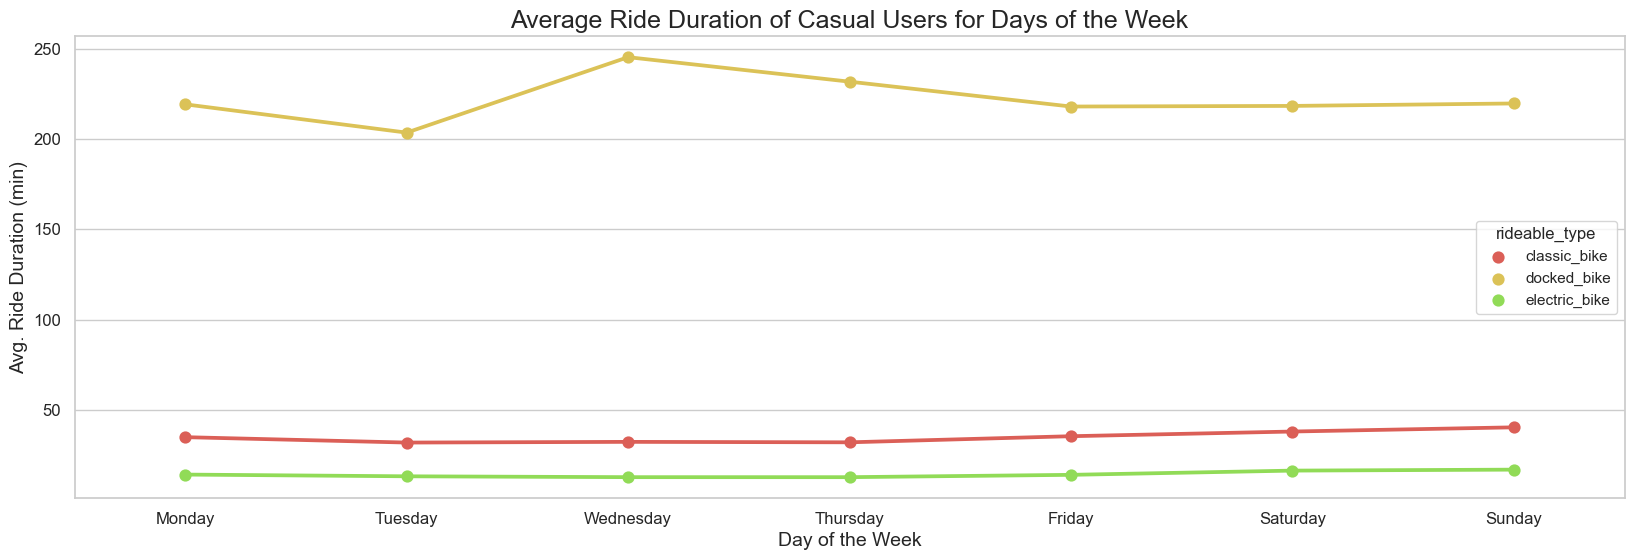

In [40]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

sns.pointplot(x = "day_of_week", y = "ride_len_min", hue = "rideable_type", order=order, data = avg_ride_len_casual_day)

plt.xlabel("Day of the Week")
plt.ylabel("Avg. Ride Duration (min)")
plt.title("Average Ride Duration of Casual Users for Days of the Week")

plt.show()

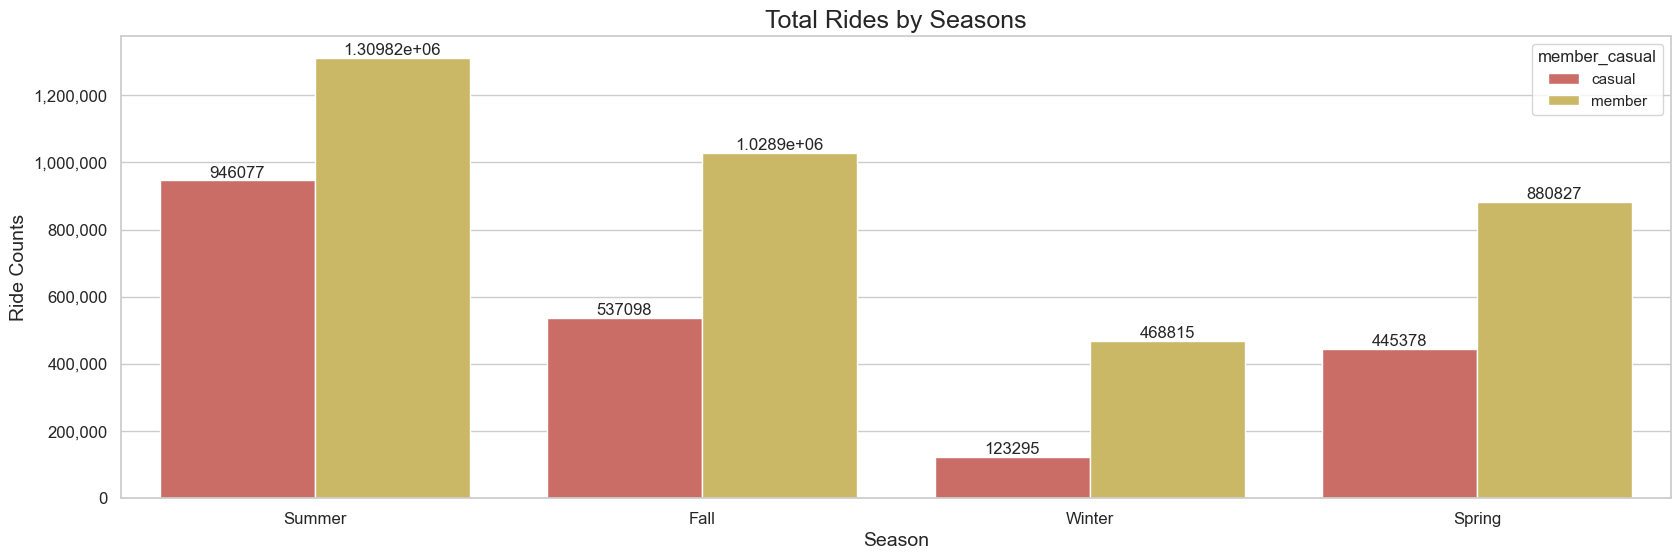

In [41]:
order = ["Summer", "Fall", "Winter", "Spring"]

axs = sns.barplot(data = rides_count_seasons, x = "season_of_year", y = "count", hue = "member_casual", order=order)

axs.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: format(int(x), ',')))

for i in axs.containers:
    axs.bar_label(i, fontsize=12)
    
plt.xlabel("Season")
plt.ylabel("Ride Counts")
plt.title("Total Rides by Seasons")

plt.show()

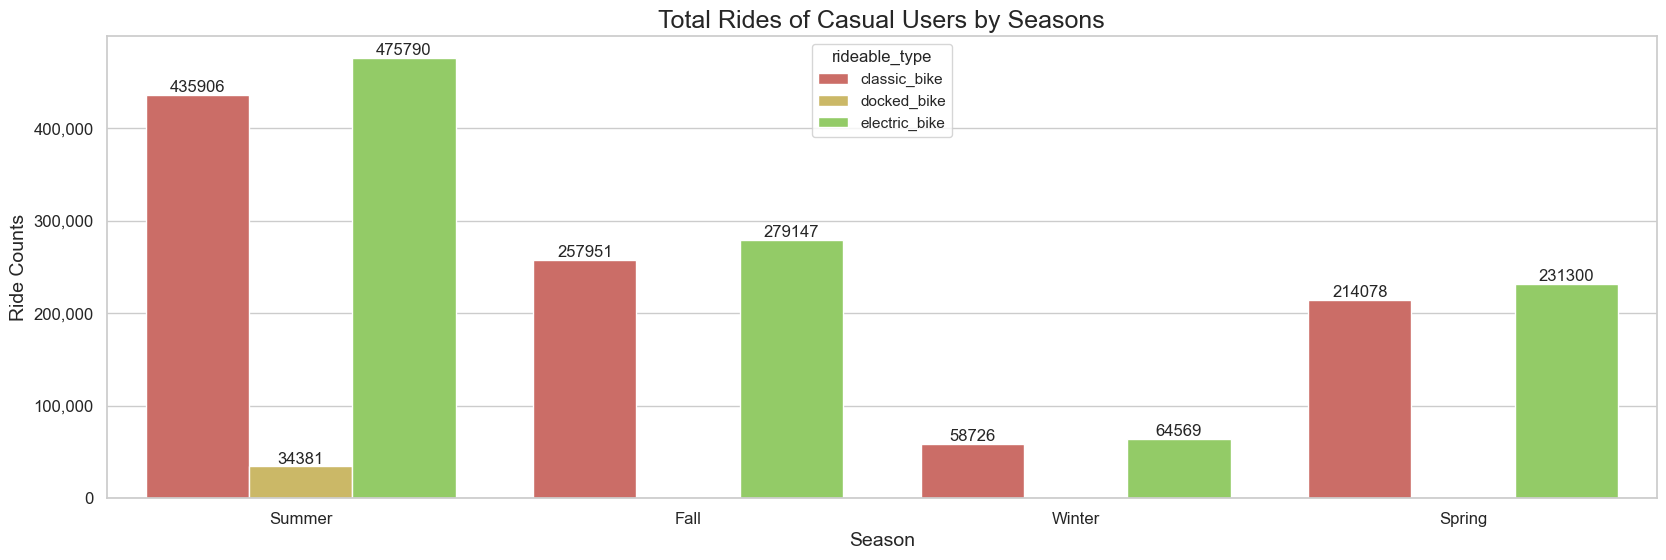

In [42]:
order = ["Summer", "Fall", "Winter", "Spring"]

axs = sns.barplot(data = rides_count_seasons_casual, x = "season_of_year", y = "count", hue = "rideable_type", order=order)

axs.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: format(int(x), ',')))

for i in axs.containers:
    axs.bar_label(i, fontsize=12)
    
plt.xlabel("Season")
plt.ylabel("Ride Counts")
plt.title("Total Rides of Casual Users by Seasons")

plt.show()

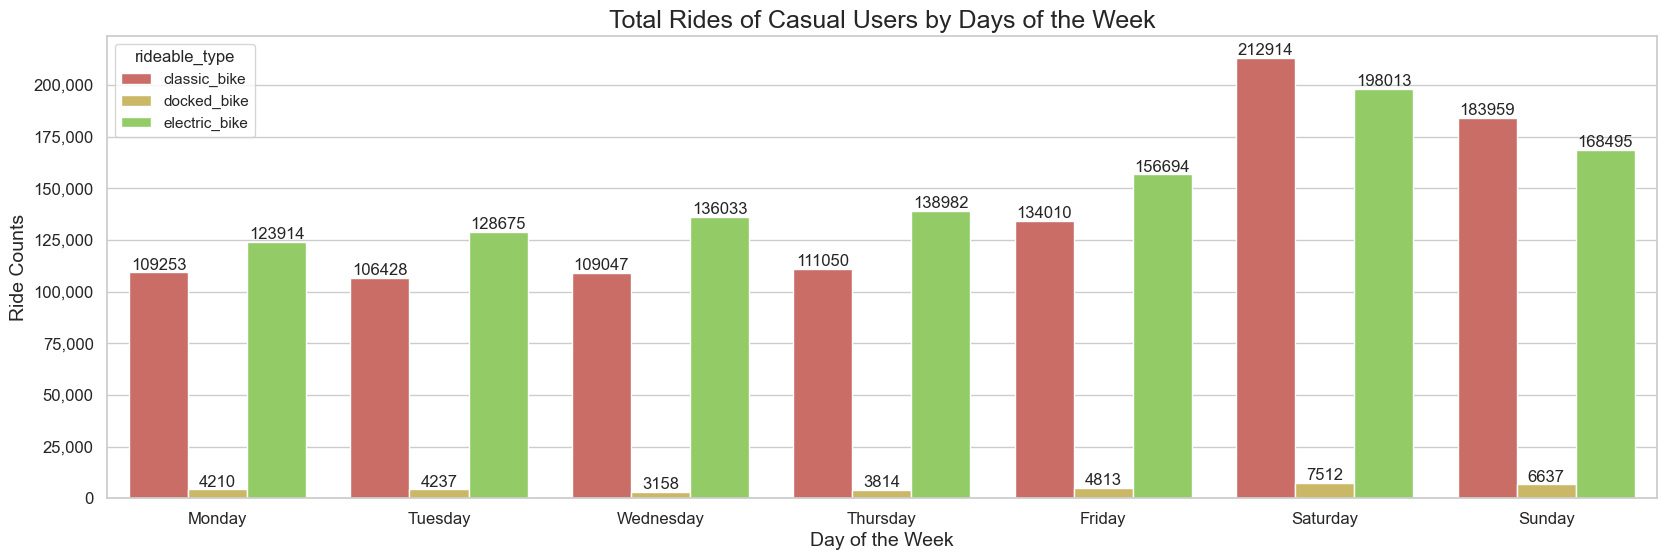

In [43]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

axs = sns.barplot(data = rides_count_casual_days, x = "day_of_week", y = "count", hue = "rideable_type", order=order)

axs.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: format(int(x), ',')))

for i in axs.containers:
    axs.bar_label(i, fontsize=12)
    
plt.xlabel("Day of the Week")
plt.ylabel("Ride Counts")
plt.title("Total Rides of Casual Users by Days of the Week")

plt.show()

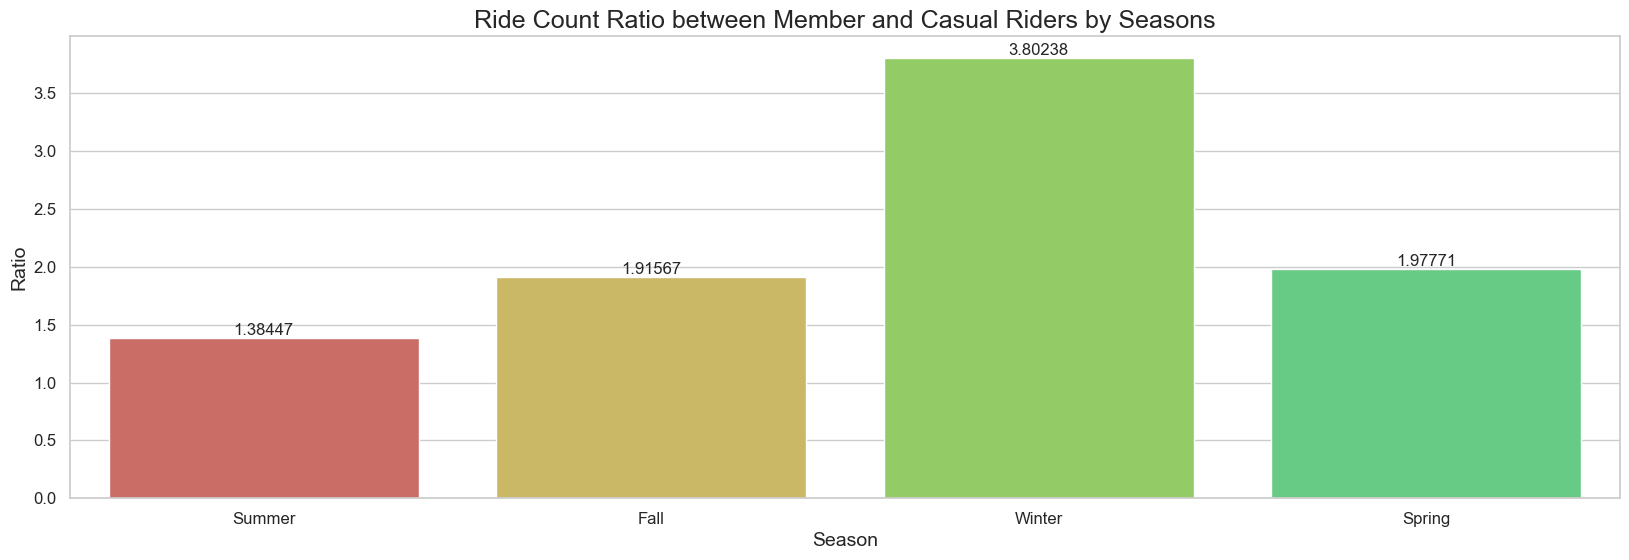

In [44]:
order = ["Summer", "Fall", "Winter", "Spring"]

axs = sns.barplot(data = ratio_data, x = "season", y = "ride_ratio", order=order)

for i in axs.containers:
    axs.bar_label(i, fontsize=12)
    
plt.xlabel("Season")
plt.ylabel("Ratio")
plt.title("Ride Count Ratio between Member and Casual Riders by Seasons")

plt.show()

In [45]:
map1 = folium.Map(location=[41.89379, -87.62029], zoom_start=14)

for i, row in start_location_casual_grouped.iterrows():
    coord = (row["start_lat"], row["start_lng"])
    folium.Marker(coord).add_to(map1)

    
map1

In [46]:
map2 = folium.Map(location=[41.89339, -87.62069], zoom_start=14)

for i, row in end_location_casual_grouped.iterrows():
    coord = (row["end_lat"], row["end_lng"])
    folium.Marker(coord).add_to(map2)
    
map2

In [47]:
map3 = folium.Map(location=[41.850421, -87.622378], zoom_start=12)

for i, row in start_location_member_grouped.iterrows():
    coord = (row["start_lat"], row["start_lng"])
    folium.Marker(coord).add_to(map3)
    
map3

In [49]:
map4 = folium.Map(location=[41.89339, -87.62069], zoom_start=14.4)

for i, row in end_location_member_grouped.iterrows():
    coord = (row["end_lat"], row["end_lng"])
    folium.Marker(coord).add_to(map4)
    
map4